# ASL Action Recognition

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [5]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()

### Download ASL Video

In [6]:
!wget -nc "https://www.dropbox.com/s/ti7ptv0gftbk5ji/computer_asl.mp4?dl=0" -O computer_asl.mp4

#ASL UDF
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/udfs/asl_action_recognition.py -O asl_action_recognition.py 

#Pickle file containing the mapping of the ASL action to index
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/udfs/asl_20_actions_map.pkl -O asl_20_actions_map.pkl

--2023-06-17 00:23:48--  https://www.dropbox.com/s/ti7ptv0gftbk5ji/computer_asl.mp4?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ti7ptv0gftbk5ji/computer_asl.mp4 [following]
--2023-06-17 00:23:48--  https://www.dropbox.com/s/raw/ti7ptv0gftbk5ji/computer_asl.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1b23fa1f2be8859c8dc4b0fd15.dl.dropboxusercontent.com/cd/0/inline/B-KD0vmNPeKcOc0w0aXMpp6ldSvPmSGRorXdg4y8I3fE4vPwpiij4yfNoyUmuEbjMWKo9NdfMb3984moFkZZXUcmUZFgPkSaTJhbIfosYgBzcD2jykeKpergPkc8Nd6UoBpSwxur7Or-stz4NTNGPnkWbKv5-lgmi57cQz3zUj7Nwg/file# [following]
--2023-06-17 00:23:49--  https://uc1b23fa1f2be8859c8dc4b0fd15.dl.dropboxusercontent.com/cd/0/inline/B-KD0vmNPeKcOc0w0aXMpp6ldSvPmSGRorXdg4y8I3fE4vPwpiij4yfNoyUmuEb

### Load video into EvaDB for analysis

In [7]:
cursor.query("DROP TABLE IF EXISTS ASL_ACTIONS;").df()
cursor.load("computer_asl.mp4", "ASL_ACTIONS", format="video").df()

06-17-2023 00:23:51 WARNING[drop_object_executor:drop_object_executor.py:_handle_drop_table:0050] Table: ASL_ACTIONS does not exist


,0
0,Number of loaded VIDEO: 1


### Create a function for analyzing the frames

In [8]:
cursor.query("DROP UDF IF EXISTS ASLActionRecognition;").df()
cursor.query("""CREATE UDF IF NOT EXISTS ASLActionRecognition
        INPUT  (Frame_Array NDARRAY UINT8(3, 16, 224, 224))
        OUTPUT (labels NDARRAY STR(ANYDIM))
        TYPE  Classification
        IMPL  'asl_action_recognition.py'
        """).df()

06-17-2023 00:23:51 WARNING[drop_object_executor:drop_object_executor.py:_handle_drop_udf:0082] UDF ASLActionRecognition does not exist, therefore cannot be dropped.


,0
0,UDF ASLActionRecognition successfully added to...


### Run the function on the video to find the ASL action

In [9]:
response = cursor.query(
    """SELECT FIRST(id), ASLActionRecognition(SEGMENT(data)) 
                  FROM ASL_ACTIONS 
                  SAMPLE 5
                  GROUP BY '16 frames';""").df()

2023-06-17 00:23:54,639	INFO worker.py:1625 -- Started a local Ray instance.


In [10]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    label = detections['aslactionrecognition.labels'][0]
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = 350, 100, 900, 500
        # object bbox
        frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
        # object label
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
        
        # frame label
        cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
    
        video.write(frame)
        # Show every 40th frame
        if frame_id % 40 == 0:
            plt.imshow(frame)
            plt.show()
    
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

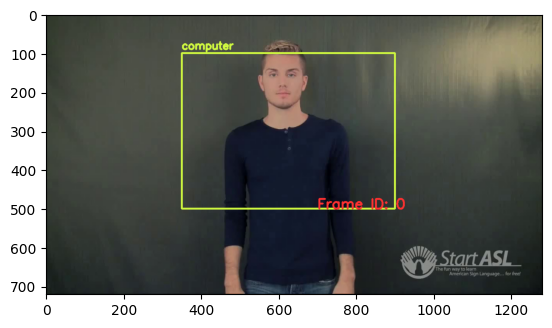

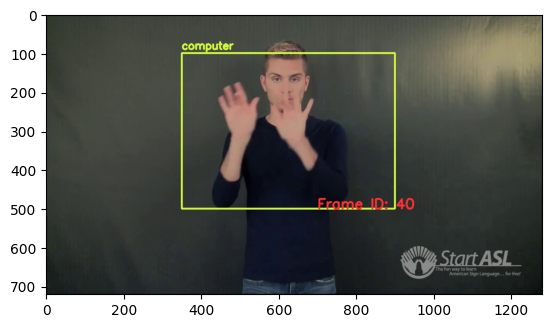

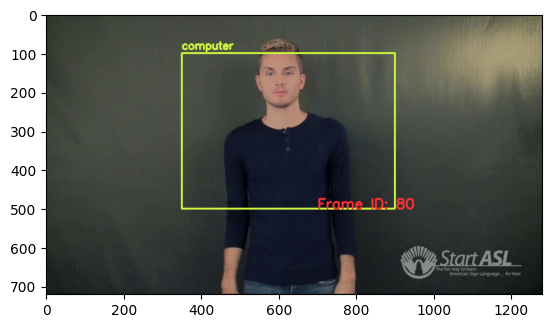

In [11]:
input_path = 'computer_asl.mp4'
output_path = 'computer_annotated.mp4'

annotate_video(response, input_path, output_path)